In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings("ignore")

def find_clumsy_directories(root='.'):
    res = []
    for dirpath, dirnames, filenames in os.walk(root):
        for dirname in dirnames:
            if 'clumsy' in dirname.lower() or 'validation' in dirname.lower():
                res.append(os.path.join(dirpath, dirname))
    return res

def reset_timestamp(df):
    # df['timestamp'] = df['timestamp'] - df['timestamp'][0]
    #reset timestamp to 0
    df['timestamp'] = df['timestamp'] - df['timestamp'].min()
    return df

def process_line(line):
    timestamp = line.split(' ')[1]
    content = line.split('  : ')[1]
#     print(content)
    pairs = content.split(',')
#     print(pairs)
    d = {}
    cpugpu = re.search("CPU4/GPU=\d+/\d+,\d+/\d+", content).group()
    cpugpu = cpugpu.split('=')[1]
    cpugpu = cpugpu.split('/')
    d['CPU Level'] = int(cpugpu[0])
    d['GPU Level'] = int(cpugpu[1].split(',')[0])
    d['CPU Frequency (MHz)'] = int(cpugpu[1].split(',')[1])
    d['GPU Frequency (MHz)'] = int(cpugpu[2])
    for x in pairs:
        tmp = x.split('=')
        if tmp[0] == 'CPU4/GPU' or len(tmp) < 2:
            continue
        if tmp[0] == 'FPS':
            d[tmp[0]] = int(tmp[1].split('/')[0])
        elif tmp[0] == 'Free':
            d[tmp[0]] = int(tmp[1][:-2])
        else:
            d[tmp[0]] = tmp[1].strip()
#     print(pairs[0].split('='))
#     d = {x.split('=')[0] : x.split('=')[1] for x in pairs}
#     print(d)
    d["timestamp"] = pd.to_datetime(timestamp, format='%H:%M:%S.%f')
    d["timestamp"] = d["timestamp"].timestamp()
#     print(d)
    return pd.DataFrame(d, index=[0])

def add_to_dataframe(df, timestamp, key, value):
    if key not in df.columns:
        df[key] = np.nan
    df.loc[timestamp, key] = value
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    for line in open(file_path, 'r', encoding='utf-16'):
        if len(line) < 300:
            continue
        new_d = process_line(line)
        df = pd.concat([df, new_d])

#     df.index.name = 'timestamp'
#     df = df.reset_index()
    if len(file_path.split('\\')[1].split('-')) == 3:
        df['altered_bandwidth'] = file_path.split('\\')[1].split('-')[1] == 'bandwidth'
        df['altered_dropchance'] = file_path.split('\\')[1].split('-')[1] == 'dropchance'
        df['bandwidth'] = int(file_path.split('\\')[1].split('-')[2][:-4]) if file_path.split('\\')[1].split('-')[1] == 'bandwidth' else 999999
        df['dropchance'] = float(file_path.split('\\')[1].split('-')[2]) if file_path.split('\\')[1].split('-')[1] == 'dropchance' else 0
    else:
        df['altered_bandwidth'] = True
        df['altered_dropchance'] = True
        df['bandwidth'] = 999999
        df['dropchance'] = 0
    df['device'] = file_path.split('\\')[2]
    df['app'] = file_path.split('\\')[3].strip('-W')
    df['app_details'] = file_path.split('\\')[4]
    df['is_record'] = 'record' in file_path.split('\\')[5]
    df['is_wireless'] = '-W' in file_path.split('\\')[3]
    df['repetition'] = file_path.split('\\')[5].strip('record') if 'record' in file_path.split('\\')[5] else file_path.split('\\')[5].strip('replay')

    # df.to_csv(f'.\\{file_path.strip(".log")}.csv', index=False)

    return df

clumsy_dirs = find_clumsy_directories()

df_aggregated = pd.DataFrame()

for clumsy in clumsy_dirs:
    for root, dirs, files in os.walk(clumsy, topdown=False):
        for name in files:
            if name == 'logcat_VrApi.log':
                print(os.path.join(root, name))
                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))]) 
                
print(df_aggregated)
df = df_aggregated
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2

,CPU Level,GPU Level,CPU Frequency (MHz),GPU Frequency (MHz),FPS,Prd,Tear,Early,Stale,Stale2/5/10/max,...,altered_bandwidth,altered_dropchance,bandwidth,dropchance,device,app,app_details,is_record,is_wireless,repetition
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,72,0ms,0,0,0,0/0/0/0,...,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,73,0ms,0,0,1,0/0/0/1,...,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,True,False,100,0.0,Quest-2,BeatSaber,PopStars-Medium,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3,4,1382,525,72,0ms,0,0,0,0/0/0/0,...,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.9
0,3,4,1382,525,73,0ms,0,0,0,0/0/0/0,...,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.9
0,3,4,1382,525,73,0ms,0,0,0,0/0/0/0,...,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.9
0,3,4,1382,525,73,0ms,0,0,0,0/0/0/0,...,True,True,999999,0.0,Quest-Pro,BeatSaber,PopStars-Medium,False,False,2.9


In [2]:
plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False,
                 "axes.spines.left": True,
                 "axes.spines.bottom": True,
                 "xtick.bottom": True,
                 "ytick.left": True,
                 "axes.edgecolor": "black",
                 "axes.grid": True,
                 "axes.linewidth": 1.5, 
                 "axes.facecolor": "white", 
                 "grid.color": "lightgray"}

# sns.set_theme(style="whitegrid", rc=custom_params)
# sns.set_palette("deep")
# sns.set(font_scale=1.7)

custom_mean = {"marker":"d",
                "markerfacecolor":"white", 
                "markeredgecolor":"black",
                "markersize":"7"}


## Bandwidth experiments

In [3]:
df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]['bandwidth'].unique()

array([   100,     30,     50,     80, 999999], dtype=int64)

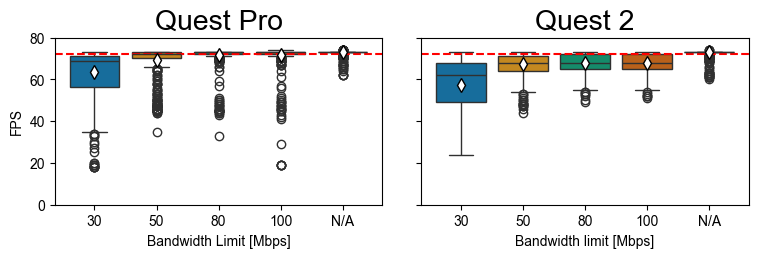

In [4]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['FPS'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=axes[0])
axes[0].axline((0, 72), slope=0, color='red', linestyle='--', linewidth=1.5)

labels = [item.get_text() for item in axes[0].get_xticklabels()]
labels[4] = 'N/A'
axes[0].set_xticklabels(labels)
axes[0].set_yticks([0, 20, 40, 60, 80])
axes[0].set_xlabel('Bandwidth Limit [Mbps]')
axes[0].set_ylim(0, 80)
axes[0].set_title('Quest Pro')


to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]

sns.boxplot(y=to_plot['FPS'], x=to_plot['bandwidth'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=axes[1])
axes[1].axline((0, 72), slope=0, color='red', linestyle='--', linewidth=1.5)

labels = [item.get_text() for item in axes[1].get_xticklabels()]
labels[4] = 'N/A'
axes[1].set_xticklabels(labels)
axes[1].set_xlabel('Bandwidth limit [Mbps]')
axes[1].set_ylim(0, 80)
axes[1].set_title('Quest 2')

plt.tight_layout()
plt.savefig('./figures/bandwidth_exp/fps_vs_bandwidth.pdf', dpi=300, format='pdf')
plt.show()


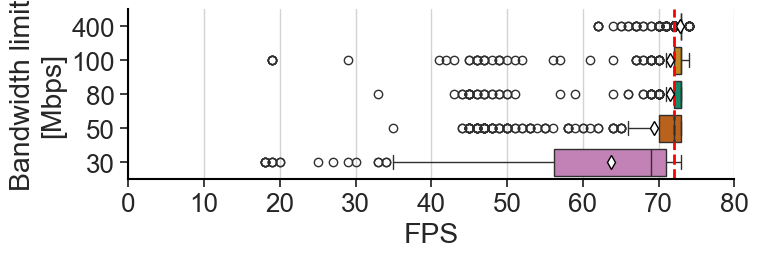

In [25]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

to_plot = df[(df['altered_bandwidth'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]
to_plot['bw_text'] = to_plot['bandwidth'].apply(lambda x: '400' if x == 999999 else str(x))
to_plot.sort_values('bandwidth', ascending=False, inplace=True)

sns.boxplot(x=to_plot['FPS'], y=to_plot['bw_text'], showmeans=True, meanprops=custom_mean, palette="colorblind", ax=ax)
# ax.axline((0, 72), slope=0, color='red', linestyle='--', linewidth=1.5)
ax.axvline(x = 72, color = 'red', linestyle='--', linewidth=2, label='72 FPS')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[4] = 'N/A'
# ax.set_xticklabels(labels)
# ax.set_xticks([0, 20, 40, 60, 80])
ax.set_xlabel('FPS')
ax.set_ylabel('Bandwidth limit\n[Mbps]')
ax.set_xlim(0, 80)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
# ax.set_title('Quest Pro')

plt.tight_layout()
plt.savefig('./figures/bandwidth_exp/Quest-Pro_fps_vs_bandwidth.pdf', dpi=300, format='pdf')
plt.show()

## Dropchance experiments

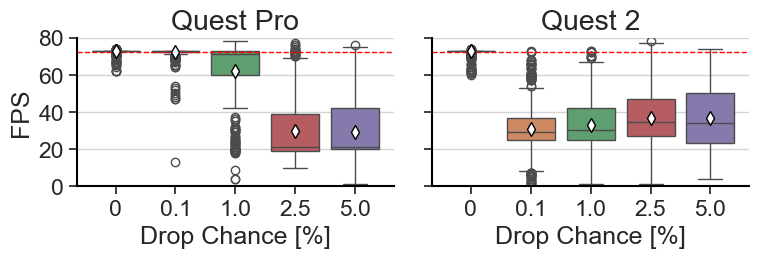

In [6]:
fig, axes = plt.subplots(figsize=(8, 3), ncols=2, sharey=True)
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

to_plot = df[(df['altered_dropchance'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-Pro')]

sns.boxplot(y=to_plot['FPS'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[0])
axes[0].axline((0, 72), slope=0, color='red', linestyle='--', linewidth=1)

labels = [float(item.get_text()) for item in axes[0].get_xticklabels()]
labels = [str(x*100) for x in labels]
labels[0] = '0'
axes[0].set_xticklabels(labels)
axes[0].set_yticks([0, 20, 40, 60, 80])
axes[0].set_xlabel('Drop Chance [%]')
axes[0].set_ylim(0, 80)
axes[0].set_title('Quest Pro')


to_plot = df[(df['altered_dropchance'] == True) & (df['is_record'] == False) & (df['device'] == 'Quest-2')]

sns.boxplot(y=to_plot['FPS'], x=to_plot['dropchance'], showmeans=True, meanprops=custom_mean, palette="deep", ax=axes[1])
axes[1].axline((0, 72), slope=0, color='red', linestyle='--', linewidth=1)

labels = [float(item.get_text()) for item in axes[1].get_xticklabels()]
labels = [str(x*100) for x in labels]
labels[0] = '0'
axes[1].set_xticklabels(labels)

axes[1].set_xlabel('Drop Chance [%]')
axes[1].set_ylim(0, 80)
axes[1].set_title('Quest 2')

plt.tight_layout()
plt.savefig('./figures/dropchance_exp/fps_vs_dropchance.pdf', dpi=300, format='pdf')
plt.show()